# Results Analysis

In [1]:
import wandb 
import dataclasses
import pandas as pd

api = wandb.Api(timeout=100)

@dataclasses.dataclass
class Run:
    config: dict
    summary: dict


def get_runs_from_sweep(sweep):
    runs = []
    experiment_stats = {}

    for run in sweep.runs:
        # discard non-test metrics from each run
        summary = {k:v for k,v in run.summary.items() if "test" in k}
        runs.append(Run(run.config, summary))

    return runs


def get_df_from_runs(runs):
    df = pd.DataFrame([run.config | run.summary for run in runs])
    return df

def convert_fairshape_format(df):
    """Adds an experiment column to the fairshape dataframe"""
    df["experiment"] = df.apply(
        lambda row: f"{row['datamodule']}_{row['datamodule.attribute_difference']}", 
        axis=1
        )
    return df

def drop_unused_columns(df, mode: str):
    if mode == "predict_attr":
        for col in df.columns:
            if "test" in col and "auc" not in col:
                df.drop(col, axis=1, inplace=True)
    
    elif mode == "predict_disease":
        for col in df.columns:
            # drop all test metrics except accuracy 
            if "test" in col and "accuracy" not in col and "auc" not in col:
                df.drop(col, axis=1, inplace=True)

    else:
        raise ValueError(f"Invalid mode: {mode}")

    return df

Get sweeps from wandb. We assume the sweeps are completed and no runs have crashed.

In [2]:
predict_attr_sweep_id = "<USERNAME>/subgroup_separability/<SWEEP_ID>"
predict_attr_sweep = api.sweep(predict_attr_sweep_id)
predict_attr_runs = get_runs_from_sweep(predict_attr_sweep)

predict_attr_df = get_df_from_runs(predict_attr_runs)
predict_attr_df = drop_unused_columns(predict_attr_df, mode="predict_attr")
print(predict_attr_df.shape)
predict_attr_df.head()

(110, 6)


,rng,model,experiment,model.predict_attr,datamodule.label_noise,test/auc
0,9,baseline,fitzpatrick17k_skin,True,0,0.895062
1,8,baseline,fitzpatrick17k_skin,True,0,0.889488
2,7,baseline,fitzpatrick17k_skin,True,0,0.901396
3,6,baseline,fitzpatrick17k_skin,True,0,0.864893
4,5,baseline,fitzpatrick17k_skin,True,0,0.890657


In [3]:
predict_disease_sweep_id = "<USERNAME>/subgroup_separability/<SWEEP_ID>"
predict_disease_sweep = api.sweep(predict_disease_sweep_id)
predict_disease_runs = get_runs_from_sweep(predict_disease_sweep)

predict_disease_df = get_df_from_runs(predict_disease_runs)
predict_disease_df = drop_unused_columns(predict_disease_df, mode="predict_disease")
print(predict_disease_df.shape)
predict_disease_df.head()

(220, 9)


,rng,model,experiment,model.predict_attr,datamodule.label_noise,test/accuracy_group_1,split_test/accuracy,split_test/auc,test/accuracy_group_0
0,9,baseline,fitzpatrick17k_skin,False,0.25,0.921212,0.808989,0.854915,0.893406
1,8,baseline,fitzpatrick17k_skin,False,0.25,0.937374,0.785268,0.821667,0.890696
2,7,baseline,fitzpatrick17k_skin,False,0.25,0.939394,0.793383,0.847700,0.892502
3,6,baseline,fitzpatrick17k_skin,False,0.25,0.907071,0.816479,0.857215,0.877145
4,5,baseline,fitzpatrick17k_skin,False,0.25,0.931313,0.807116,0.861531,0.888889


Analyse the predict_attr results

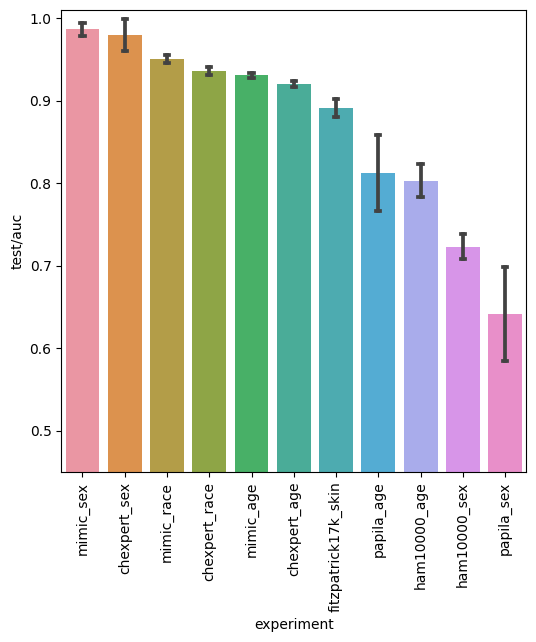

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(6, 6))

sns.barplot(
    data=predict_attr_df,
    x="experiment",
    y="test/auc",
    errorbar="sd",
    order=predict_attr_df.groupby("experiment")
        .agg({"test/auc": "mean"})
        .sort_values("test/auc", ascending=False)
        .index,
    capsize=0.1,
    ax=axs
)
axs.set_ylim(0.45, 1.01)
axs.set_xticklabels(predict_attr_df.groupby("experiment")
        .agg({"test/auc": "mean"})
        .sort_values("test/auc", ascending=False)
        .index, rotation=90
        )

plt.show()



In [5]:
attr_results_agg = predict_attr_df.groupby("experiment").agg(
    {"test/auc": ["mean", "std"]}
).sort_values(("test/auc", "mean"), ascending=False)
attr_results_agg

test/auc          
                         mean       std
experiment                             
mimic_sex            0.986394  0.007749
chexpert_sex         0.979751  0.019790
mimic_race           0.950730  0.004963
chexpert_race        0.935971  0.005270
mimic_age            0.930576  0.002520
chexpert_age         0.920307  0.003214
fitzpatrick17k_skin  0.891253  0.010444
papila_age           0.812474  0.046200
ham10000_age         0.803266  0.020465
ham10000_sex         0.723243  0.015004
papila_sex           0.641984  0.056934

Now, analyse results for predicting disease (ERM only)

In [6]:
disease_results_df = predict_disease_df
disease_results_df.head()

,rng,model,experiment,model.predict_attr,datamodule.label_noise,test/accuracy_group_1,split_test/accuracy,split_test/auc,test/accuracy_group_0
0,9,baseline,fitzpatrick17k_skin,False,0.25,0.921212,0.808989,0.854915,0.893406
1,8,baseline,fitzpatrick17k_skin,False,0.25,0.937374,0.785268,0.821667,0.890696
2,7,baseline,fitzpatrick17k_skin,False,0.25,0.939394,0.793383,0.847700,0.892502
3,6,baseline,fitzpatrick17k_skin,False,0.25,0.907071,0.816479,0.857215,0.877145
4,5,baseline,fitzpatrick17k_skin,False,0.25,0.931313,0.807116,0.861531,0.888889


In [7]:
# split into noise and no noise and aggregate by experiment

noise_df = disease_results_df[disease_results_df["datamodule.label_noise"] > 0]
no_noise_df = disease_results_df[disease_results_df["datamodule.label_noise"] == 0]

noise_df_agg = noise_df.groupby("experiment").agg(
    {"test/accuracy_group_0": ["mean", "std"], "test/accuracy_group_1": ["mean", "std"], 
     "split_test/auc": ["mean", "std"]
    }
    )
noise_df_agg.columns = ["_".join(col) for col in noise_df_agg.columns]
no_noise_df_agg = no_noise_df.groupby("experiment").agg(
    {"test/accuracy_group_0": ["mean", "std"], "test/accuracy_group_1": ["mean", "std"],
     "split_test/auc": ["mean", "std"]
     }
    )

no_noise_df_agg.columns = ["_".join(col) for col in no_noise_df_agg.columns]

print(noise_df_agg.shape)
noise_df_agg.head()

(11, 6)


,test/accuracy_group_0_mean,test/accuracy_group_0_std,test/accuracy_group_1_mean,test/accuracy_group_1_std,split_test/auc_mean,split_test/auc_std
experiment,,,,,,
chexpert_age,0.831145,0.020821,0.906556,0.014347,0.853908,0.010615
chexpert_race,0.880686,0.026541,0.830384,0.042722,0.851024,0.008392
chexpert_sex,0.867673,0.028604,0.799430,0.051706,0.945462,0.014456
fitzpatrick17k_skin,0.887082,0.008125,0.925657,0.010510,0.849393,0.011024
ham10000_age,0.905947,0.023445,0.778136,0.033896,0.774660,0.010705


In [8]:
# subtract no_noise results from noise results to get the difference
# we assume that the results are independent (i.e. we cannot treat results with the
# same seed as paired), hence we use the formula for the std of the difference of two 
# independent RVs. Negative difference means results have deteriorated
# we additionally multiply by 100 to convert accuracy to percentage points

import numpy as np
from scipy import stats


diff_df = pd.DataFrame()
diff_df["experiment"] = noise_df_agg.index

for col in noise_df_agg.columns:
    if "mean" in col and "split" not in col:
        diff_df[col] = 100 * (noise_df_agg[col].values - no_noise_df_agg[col].values)

    if "std" in col and "split" not in col:
        # std of subtracted independent RVs is sqrt of sum of squares of stds
        diff_df[col] = 100 * np.sqrt(noise_df_agg[col].values**2 + no_noise_df_agg[col].values**2)

diff_df["split_test/auc_mean"] = noise_df_agg["split_test/auc_mean"].values
diff_df["split_test/auc_std"] = noise_df_agg["split_test/auc_std"].values

# perform Mann-Whitney U test for each experiment
u_results_group_0 = {}
u_results_group_1 = {}

for experiment in diff_df["experiment"].unique():
    u_results_group_0[experiment] = stats.mannwhitneyu(
        no_noise_df[no_noise_df["experiment"] == experiment]["test/accuracy_group_0"].values,
        noise_df[noise_df["experiment"] == experiment]["test/accuracy_group_0"].values,
        alternative="greater"
    )
    u_results_group_1[experiment] = stats.mannwhitneyu(
        no_noise_df[no_noise_df["experiment"] == experiment]["test/accuracy_group_1"].values,
        noise_df[noise_df["experiment"] == experiment]["test/accuracy_group_1"].values,
        alternative="greater"
    )

diff_df["u_group_0"] = diff_df["experiment"].map(
    {experiment: u_results_group_0[experiment].statistic for experiment in diff_df["experiment"].unique()})

diff_df["u_group_1"] = diff_df["experiment"].map(
    {experiment: u_results_group_1[experiment].statistic for experiment in diff_df["experiment"].unique()})
diff_df["p_group_0"] = diff_df["experiment"].map(
    {experiment: u_results_group_0[experiment].pvalue for experiment in diff_df["experiment"].unique()})
diff_df["p_group_1"] = diff_df["experiment"].map(
    {experiment: u_results_group_1[experiment].pvalue for experiment in diff_df["experiment"].unique()})


# adjust for multiple testing with holm-bonferroni
# add columns with adjusted p-values, calculated by sorting p-values,
# multiplying the smallest by the number of tests, 
# second smallest by the number of tests minus 1, etc.
diff_df["p_group_0_adj"] = diff_df.sort_values("p_group_0")["p_group_0"] * np.flip(np.arange(1, len(diff_df) + 1))
diff_df["p_group_1_adj"] = diff_df.sort_values("p_group_1")["p_group_1"] * np.flip(np.arange(1, len(diff_df) + 1))
 

# add columns with predict_attr results
diff_df["predict_attr_mean"] = diff_df["experiment"].map(
    attr_results_agg[("test/auc", "mean")]
)
diff_df["predict_attr_std"] = diff_df["experiment"].map(
    attr_results_agg[("test/auc", "std")]
)

# sort rows by predict_attr results
diff_df = diff_df.sort_values("predict_attr_mean", ascending=True)


# rename experiments from snake_case to Kebab-Case, capitalize first letter and after hyphen
diff_df["experiment"] = diff_df["experiment"].map(
    {experiment: experiment.replace("_", "\n").title() for experiment in diff_df["experiment"].unique()}
)

# rename Mimic to MIMIC, Papila to PAPILA, and Ham10000 to HAM10000
diff_df["experiment"] = diff_df["experiment"].map(
    {experiment: experiment.replace("Mimic", "MIMIC").replace("Papila", "PAPILA").replace("Ham10000", "HAM10000").replace("Chexpert", "CheXpert") for experiment in diff_df["experiment"].unique()}
)


diff_df

,experiment,test/accuracy_group_0_mean,test/accuracy_group_0_std,test/accuracy_group_1_mean,test/accuracy_group_1_std,split_test/auc_mean,split_test/auc_std,u_group_0,u_group_1,p_group_0,p_group_1,p_group_0_adj,p_group_1_adj,predict_attr_mean,predict_attr_std
10,PAPILA\nSex,10.000001,21.564335,0.142857,11.630166,0.623968,0.065933,30.0,47.0,0.940860,0.604989,1.881720,1.209978,0.641984,0.056934
5,HAM10000\nSex,0.478821,3.280635,0.283225,2.820583,0.689177,0.009552,48.0,53.5,0.575030,0.410098,2.300121,1.230295,0.723243,0.015004
4,HAM10000\nAge,0.152144,3.139455,-0.215054,3.898965,0.774660,0.010705,45.5,54.5,0.647696,0.381011,1.943087,1.524043,0.803266,0.020465
9,PAPILA\nAge,7.619047,8.054675,2.826087,9.703112,0.748214,0.048614,18.0,32.0,0.993574,0.922354,0.993574,0.922354,0.812474,0.046200
3,Fitzpatrick17K\nSkin,-0.117435,0.988692,-0.666666,1.302470,0.849393,0.011024,51.5,69.5,0.469815,0.074386,2.818889,0.371929,0.891253,0.010444
0,CheXpert\nAge,-0.936853,3.333917,-1.837078,2.066015,0.853908,0.010615,61.5,85.0,0.202751,0.004554,1.419258,0.031880,0.920307,0.003214
6,MIMIC\nAge,-0.241780,3.320141,-2.904233,3.943333,0.835927,0.013784,51.0,77.0,0.484925,0.022577,2.424625,0.135464,0.930576,0.002520
1,CheXpert\nRace,-1.547716,3.292378,-5.214389,4.775361,0.851024,0.008392,68.0,88.0,0.092938,0.002286,0.743507,0.018284,0.935971,0.005270
7,MIMIC\nRace,-2.577952,3.686000,-5.525497,3.869716,0.791595,0.015356,79.0,92.0,0.015605,0.000853,0.156045,0.007678,0.950730,0.004963
2,CheXpert\nSex,-2.589598,3.330679,-8.418053,5.688703,0.945462,0.014456,77.0,94.0,0.022577,0.000504,0.203196,0.005040,0.979751,0.019790


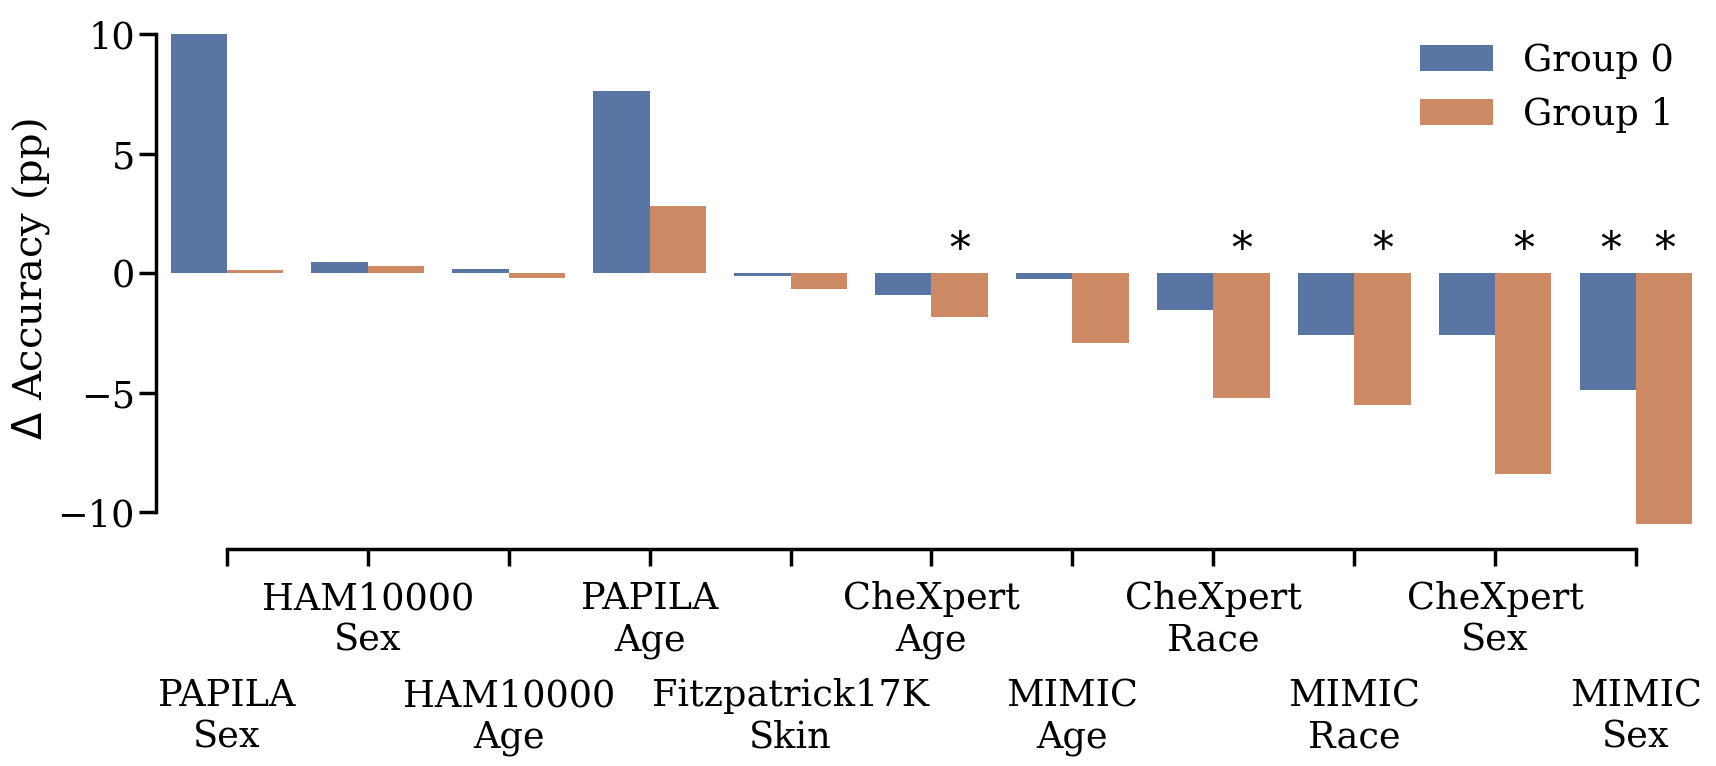

In [9]:
# massage data for plotting: combine accuracy columns,
# then create an indicator column for which accuracy group the row is for

plt.rcParams['font.family'] = "serif"
sns.set_context("poster", font_scale=1.2)
fig, axs = plt.subplots(1, 1, figsize=(20, 7))

plot_diff_df = diff_df.melt(
    id_vars=["experiment", "predict_attr_mean", "predict_attr_std"],
    value_vars=["test/accuracy_group_0_mean", "test/accuracy_group_1_mean"],
    var_name="group",
    value_name="accuracy"
)


sns.barplot(
    data=plot_diff_df,
    x="experiment",
    y="accuracy",
    hue="group",
    # sort by predict_attr_mean
    order=plot_diff_df.groupby("experiment").agg({"predict_attr_mean": "mean"})
        .sort_values("predict_attr_mean", ascending=True).index,
    ax=axs,
    palette="deep"
)

axs.set_xticklabels(plot_diff_df.groupby("experiment").agg({"predict_attr_mean": "mean"})
    .sort_values("predict_attr_mean", ascending=True).index, rotation=00)


sns.despine(fig=fig, ax=axs, trim=True)

axs.set_ylabel(r"$\Delta $ Accuracy (pp)")
axs.set_xlabel("")


# add asterisks for p < 0.05
for i, experiment in enumerate(plot_diff_df["experiment"].unique()):
    if diff_df[diff_df["experiment"] == experiment]["p_group_0_adj"].values[0] < 0.05:
        axs.text(
            i - 0.25, 0.5, "*",
            rotation=00, fontsize=30
        )
    if diff_df[diff_df["experiment"] == experiment]["p_group_1_adj"].values[0] < 0.05:
        axs.text(
            i + 0.13, 0.5, "*",
            rotation=00, fontsize=30
        )


# change legend labels to no underdiagnosis and underdiagnosis
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, ["Group 0", "Group 1"])

# remove box around legend
axs.get_legend().set_frame_on(False)

# alternate height level of xticklabels to prevent overlapping
for i, label in enumerate(axs.get_xticklabels()):
    if i % 2 == 0:
        label.set_y(-0.2)
    else:
        label.set_y(-0.02)


import os
os.makedirs("test_outputs", exist_ok=True)
plt.savefig("test_outputs/accuracy_group_diff.eps", bbox_inches="tight", dpi=1200, format="eps")
plt.show()

Now analyse results with SPLIT

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


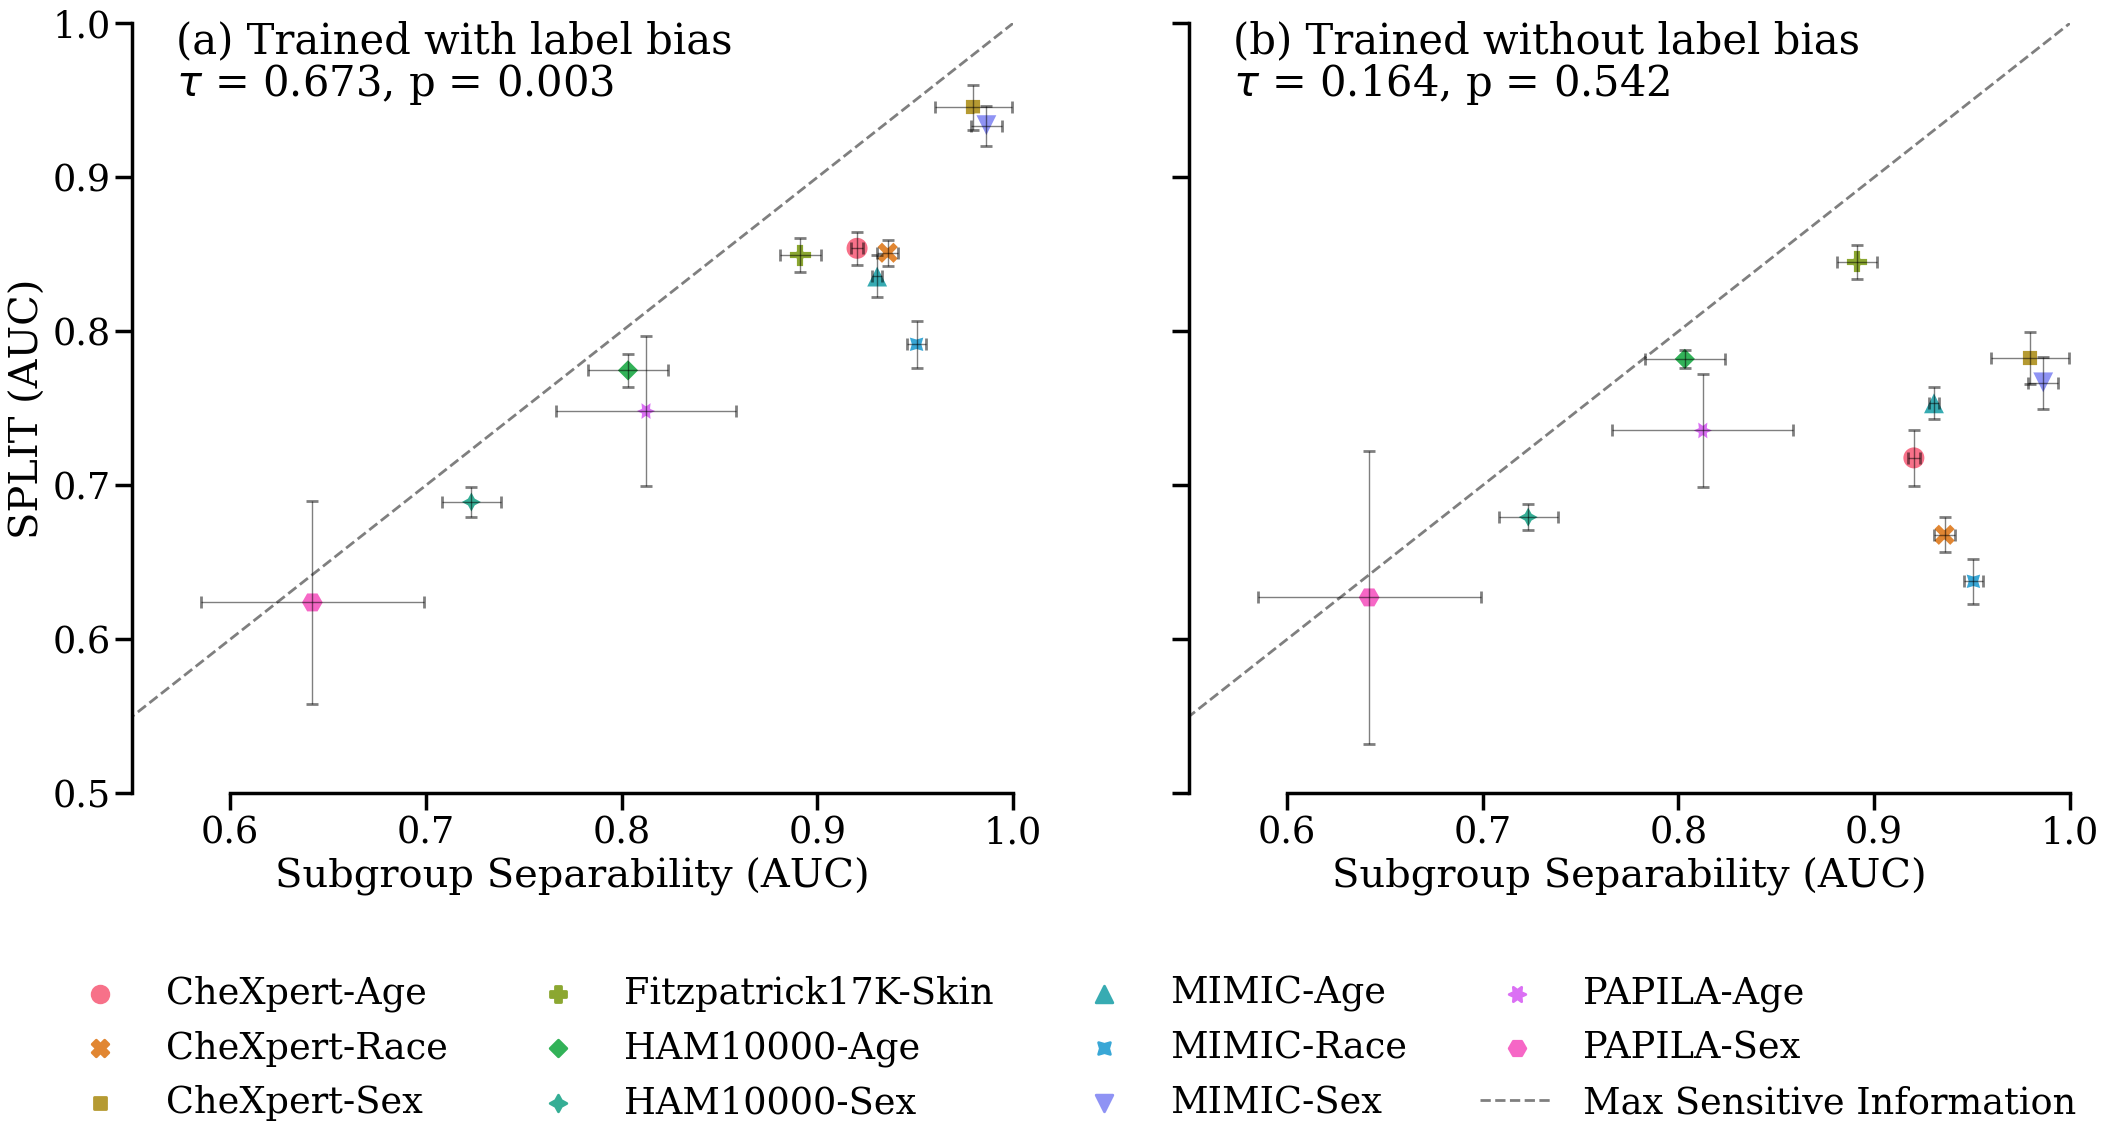

In [10]:

fig, axs = plt.subplots(1, 2, figsize=(25, 10), sharey=True)


for ax, df in zip(axs, [noise_df_agg, no_noise_df_agg]):
    plot_df = df.reset_index().copy()

    # add columns with predict_attr results
    plot_df["predict_attr_mean"] = plot_df["experiment"].map(
        attr_results_agg[("test/auc", "mean")]
    )
    plot_df["predict_attr_std"] = plot_df["experiment"].map(
        attr_results_agg[("test/auc", "std")]
    )

    # rename experiments from snake_case to Kebab-Case, capitalize first letter and after hyphen
    plot_df["experiment"] = plot_df["experiment"].map(
        {experiment: experiment.replace("_", "-").title() for experiment in plot_df["experiment"].unique()}
    )

    # rename Mimic to MIMIC, Papila to PAPILA, and Ham10000 to HAM10000
    plot_df["experiment"] = plot_df["experiment"].map(
        {experiment: experiment.replace("Mimic", "MIMIC").replace("Papila", "PAPILA").replace("Ham10000", "HAM10000").replace("Chexpert", "CheXpert") for experiment in plot_df["experiment"].unique()}
    )

    # get kendall tau correlation between predict_attr and split_test
    tau, p = stats.kendalltau(
        plot_df["predict_attr_mean"],
        plot_df["split_test/auc_mean"]
    )
    
    # add kendall tau correlation to plot
    ax.text(
        0.05, 0.95, f"$\\tau$ = {tau:.3f}, p = {p:.3f}",
        transform=ax.transAxes,
        fontsize=30,
        verticalalignment="top",
        # bbox=dict(boxstyle="none", facecolor="white", alpha=0.5)
    )

    sns.scatterplot(
        data=plot_df,
        x="predict_attr_mean",
        y="split_test/auc_mean",
        hue="experiment",
        style="experiment",
        ax=ax,
        s=270,
    )

    ax.errorbar(
        x=plot_df["predict_attr_mean"],
        y=plot_df["split_test/auc_mean"],
        xerr=plot_df["predict_attr_std"],
        yerr=plot_df["split_test/auc_std"],
        fmt="none",
        ecolor="black",
        elinewidth=1,
        capsize=4,
        capthick=2,
        alpha=0.5,
    )

    # add y=x plot
    ax.plot(
        [0, 1],
        [0, 1],
        linestyle="--",
        color="black",
        alpha=0.5,
        linewidth=2,
        # add to legent
        label="Max Sensitive Information"
    )

    ax.set_xlabel("Subgroup Separability (AUC)")
    ax.set_ylabel(f"SPLIT (AUC)")

    ax.set_xlim(0.55, 1)
    ax.set_ylim(0.5, 1)


sns.despine(fig=fig, trim=True)

# share same legend for all plots
handles, labels = axs[0].get_legend_handles_labels()

# add caption to each plot
for ax, caption in zip(axs, ["(a) Trained with label bias", "(b) Trained without label bias"]):
    ax.text(
        0.05, 0.95, caption,
        transform=ax.transAxes,
        fontsize=30,
        verticalalignment="bottom",
        # bbox=dict(boxstyle="none", facecolor="white", alpha=0.5)
    )

fig.legend(handles, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5,-0.25)).set_frame_on(False)


#turn off legend for all plots
for ax in axs.flat:
    ax.get_legend().remove()

plt.savefig("test_outputs/attr_split_test.eps", bbox_inches="tight", dpi=1200, format="eps")

plt.show()


Now perform ablation over label noise values

In [11]:
ln_ablation_sweep_id = "<USERNAME>/subgroup_separability/<SWEEP_ID>"
ln_ablation_sweep = api.sweep(ln_ablation_sweep_id)
ln_ablation_runs = get_runs_from_sweep(ln_ablation_sweep)

ln_ablation_df = get_df_from_runs(ln_ablation_runs)
ln_ablation_df = drop_unused_columns(ln_ablation_df, mode="predict_disease")

# convert accuracy to %
ln_ablation_df["test/accuracy_group_0"] = ln_ablation_df["test/accuracy_group_0"] * 100
ln_ablation_df["test/accuracy_group_1"] = ln_ablation_df["test/accuracy_group_1"] * 100

# convert ln to %
ln_ablation_df["datamodule.label_noise"] = ln_ablation_df["datamodule.label_noise"] * 100

print(ln_ablation_df.shape)
ln_ablation_df.head()

(165, 7)


,rng,model,experiment,model.predict_attr,datamodule.label_noise,test/accuracy_group_1,test/accuracy_group_0
0,2,baseline,fitzpatrick17k_skin,False,50.0,91.111112,87.804878
1,1,baseline,fitzpatrick17k_skin,False,50.0,91.717172,88.527554
2,0,baseline,fitzpatrick17k_skin,False,50.0,90.303028,88.075882
3,2,baseline,papila_sex,False,50.0,81.428570,83.333331
4,1,baseline,papila_sex,False,50.0,78.571427,61.111110


In [12]:
ln_ablation_df_agg = ln_ablation_df.groupby(["experiment", "datamodule.label_noise"]).agg(
    {
        "test/accuracy_group_0": ["mean", "std"],
        "test/accuracy_group_1": ["mean", "std"],
    }
)
ln_ablation_df_agg.columns = ["_".join(col) for col in ln_ablation_df_agg.columns]

ln_ablation_df_agg.head()


test/accuracy_group_0_mean  \
experiment   datamodule.label_noise                               
chexpert_age 0.0                                      85.007600   
             12.5                                     80.378610   
             25.0                                     82.478929   
             37.5                                     83.068492   
             50.0                                     70.296164   

                                     test/accuracy_group_0_std  \
experiment   datamodule.label_noise                              
chexpert_age 0.0                                      1.037194   
             12.5                                     0.757719   
             25.0                                     2.515879   
             37.5                                     3.564922   
             50.0                                    11.571583   

                                     test/accuracy_group_1_mean  \
experiment   datamodule.label_noise                               
chexpert_age 0.0                                      93.152682   
             12.5                                     89.360150   
             25.0                                     90.067043   
             37.5                                     89.884708   
             50.0                                     48.928441   

                                     test/accuracy_group_1_std  
experiment   datamodule.label_noise                             
chexpert_age 0.0                                      0.667238  
             12.5                                     1.205327  
             25.0                                     2.482966  
             37.5                                     2.510821  
             50.0                                    28.892733

In [13]:
# percentage point degradation compared to no label noise
ln_ablation_diff_df = pd.DataFrame()
ln_ablation_diff_df["experiment"] = ln_ablation_df_agg.index.get_level_values(0)
ln_ablation_diff_df["label_noise"] = ln_ablation_df_agg.index.get_level_values(1)

for experiment in ln_ablation_diff_df["experiment"].unique():
    for noise in ln_ablation_diff_df["label_noise"].unique():
        ln_ablation_diff_df.loc[
            (ln_ablation_diff_df["experiment"] == experiment) & (ln_ablation_diff_df["label_noise"] == noise),
            "group_0_diff"
        ] = ln_ablation_df_agg.loc[
            (experiment, noise),
            "test/accuracy_group_0_mean"
        ] - ln_ablation_df_agg.loc[
            (experiment, 0),
            "test/accuracy_group_0_mean"
        ]
        
        ln_ablation_diff_df.loc[
            (ln_ablation_diff_df["experiment"] == experiment) & (ln_ablation_diff_df["label_noise"] == noise),
            "group_1_diff"
        ] = ln_ablation_df_agg.loc[
            (experiment, noise),
            "test/accuracy_group_1_mean"
        ] - ln_ablation_df_agg.loc[
            (experiment, 0),
            "test/accuracy_group_1_mean"
        ]

ln_ablation_diff_df.head()

,experiment,label_noise,group_0_diff,group_1_diff
0,chexpert_age,0.0,0.000000,0.000000
1,chexpert_age,12.5,-4.628990,-3.792532
2,chexpert_age,25.0,-2.528671,-3.085639
3,chexpert_age,37.5,-1.939108,-3.267974
4,chexpert_age,50.0,-14.711436,-44.224241


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


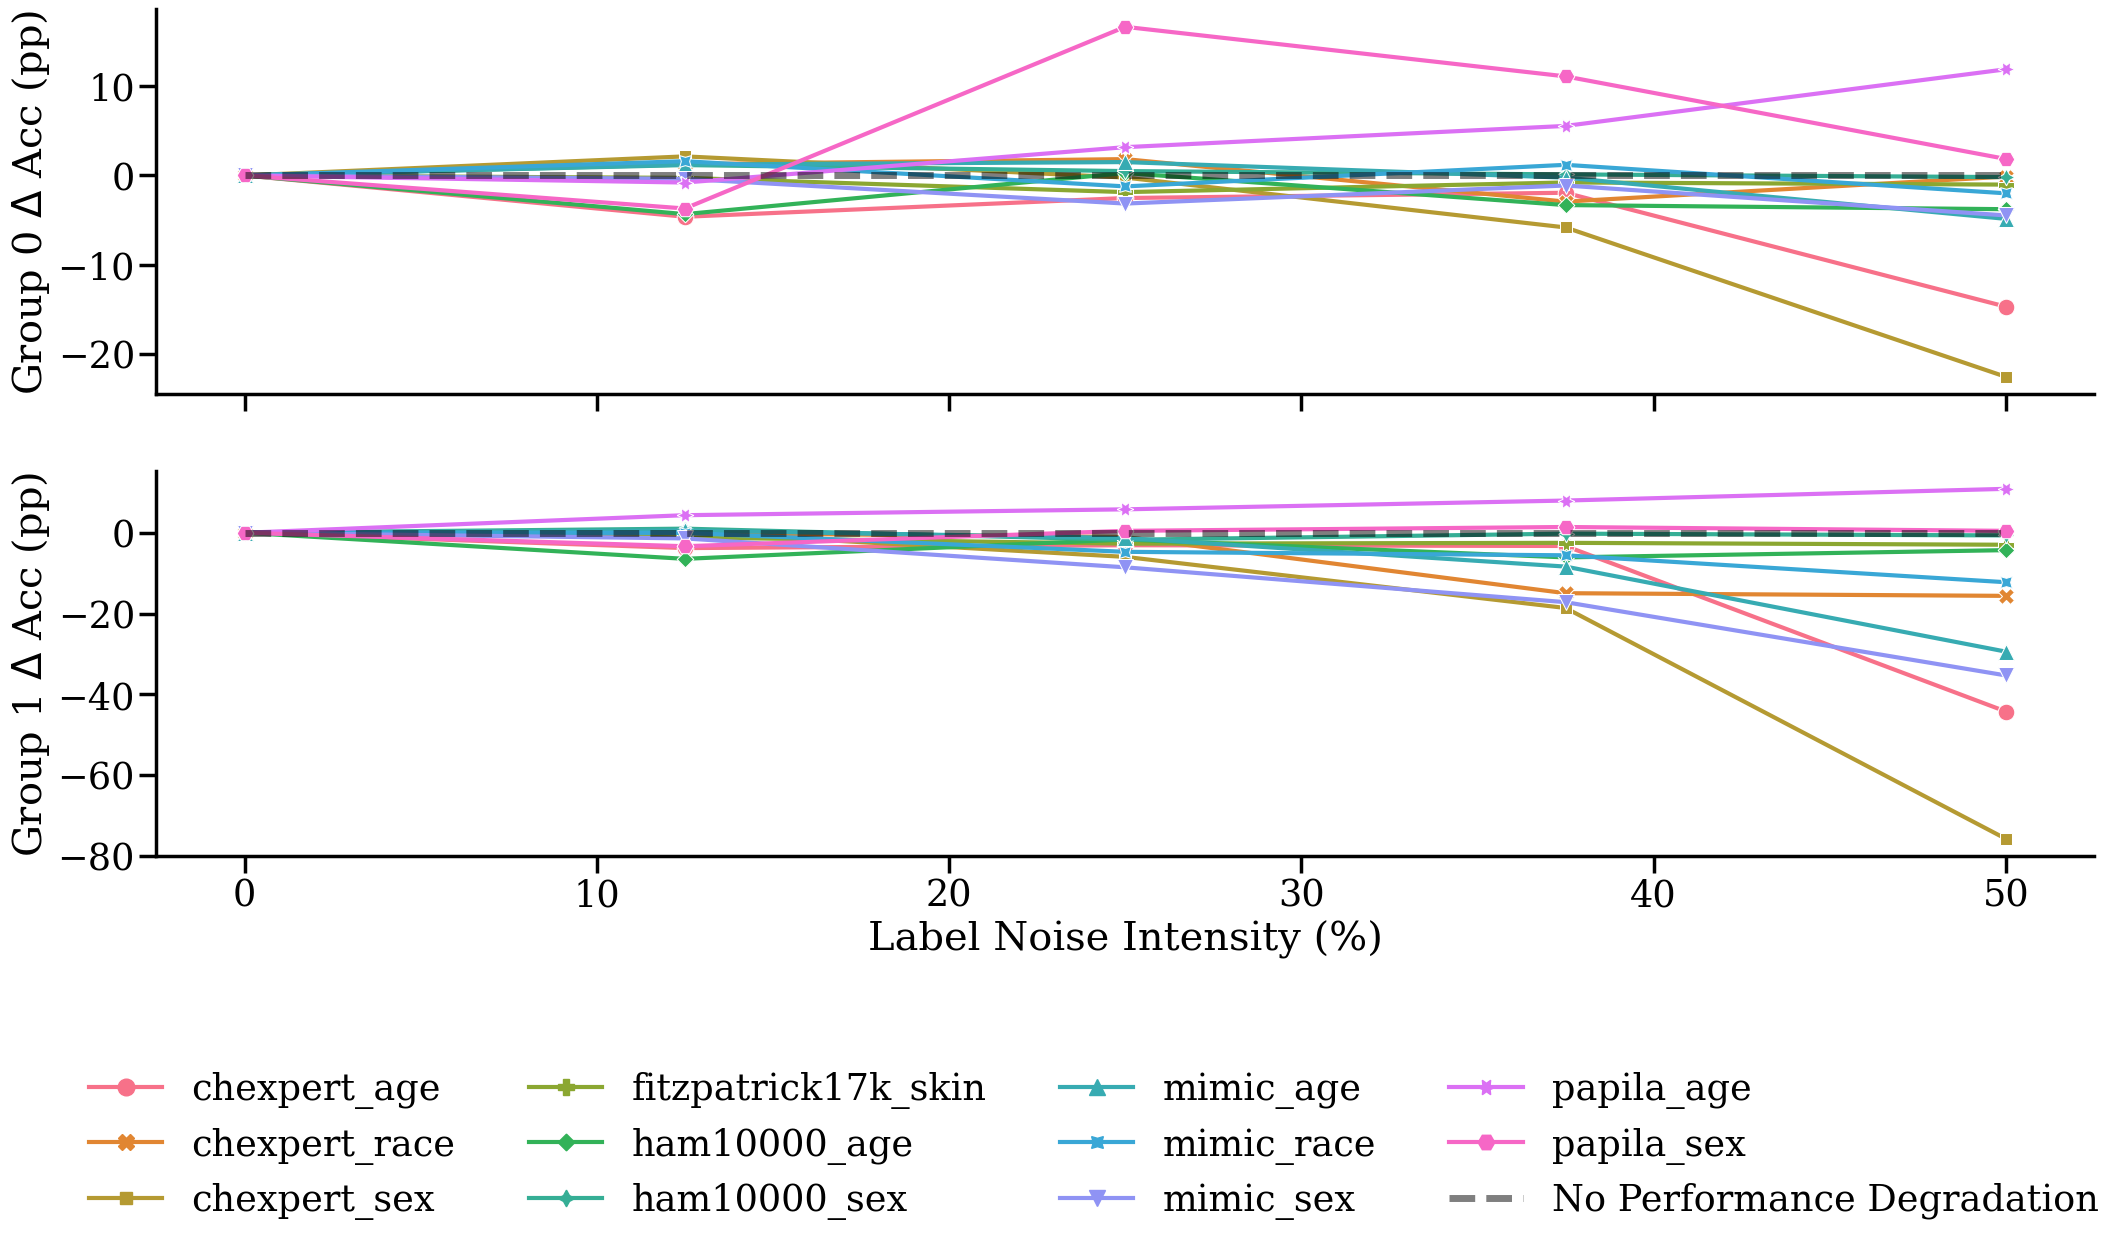

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(25, 11), sharex=True)
sns.lineplot(data=ln_ablation_diff_df, x="label_noise", y="group_0_diff", hue="experiment", style="experiment", markers=True, dashes=False, ax=axs[0])
sns.lineplot(data=ln_ablation_diff_df, x="label_noise", y="group_1_diff", hue="experiment", style="experiment", markers=True, dashes=False, ax=axs[1])

# rename experiments from snake_case to Kebab-Case, capitalize first letter and after hyphen
ln_ablation_diff_df["experiment"] = ln_ablation_diff_df["experiment"].map(
    {experiment: experiment.replace("_", "-").title() for experiment in ln_ablation_diff_df["experiment"].unique()}
)

# rename Mimic to MIMIC, Papila to PAPILA, and Ham10000 to HAM10000
ln_ablation_diff_df["experiment"] = ln_ablation_diff_df["experiment"].map(
    {experiment: experiment.replace("Mimic", "MIMIC").replace("Papila", "PAPILA").replace("Ham10000", "HAM10000").replace("Chexpert", "CheXpert") for experiment in ln_ablation_diff_df["experiment"].unique()}
)

axs[0].set_xlabel("Label Noise Intensity")
axs[0].set_ylabel(r"Group 0 $\Delta$ Acc (pp)")
axs[1].set_ylabel(r"Group 1 $\Delta$ Acc (pp)")
axs[1].set_xlabel("Label Noise Intensity (%)")

sns.despine(fig=fig, trim=False)

axs[0].plot(
    [0, 50],
    [0, 0],
    linestyle="--",
    color="black",
    alpha=0.5,
    linewidth=5,
    label="No Performance Degradation"
)
axs[1].plot(
    [0, 50],
    [0, 0],
    linestyle="--",
    color="black",
    alpha=0.5,
    linewidth=5,
    label="No Performance Degradation"
)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, bbox_to_anchor=(0.5,-0.25)).set_frame_on(False)

#turn off legend for all plots
for ax in axs.flat:
    ax.get_legend().remove()

plt.savefig("test_outputs/ln_ablation.eps", bbox_inches="tight", dpi=1200, format="eps")